In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objs as go
import matplotlib.pyplot as plt

from ostk.physics.units import Length
from ostk.physics.units import Angle
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.time import Interval
from ostk.physics.time import DateTime
from ostk.physics.time import Scale
from ostk.physics.coordinate import Position
from ostk.physics.coordinate import Velocity
from ostk.physics import Environment
from ostk.physics.environment.objects.celestial_bodies import Earth

from ostk.astrodynamics import Trajectory
from ostk.astrodynamics.trajectory import State
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory.orbit.models import Kepler
from ostk.astrodynamics.trajectory.orbit.models.kepler import COE

from utils import propagator, convertState

%load_ext autoreload
%autoreload 2

/srv/conda/envs/notebook/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for ostk::physics::time::DateTime already registered; second conversion method ignored.

/srv/conda/envs/notebook/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for ostk::math::obj::IntervalBase::Type already registered; second conversion method ignored.



Set up an OSTk reference environment and orbit.

In [2]:
environment = Environment.default()

a = Length.kilometers(7000.0)
e = 0.0001
i = Angle.degrees(35.0)
raan = Angle.degrees(40.0)
aop = Angle.degrees(45.0)
nu = Angle.degrees(50.0)

coe = COE(a, e, i, raan, aop, nu)

epoch = Instant.date_time(DateTime(2020, 1, 1, 0, 0, 0), Scale.UTC)
earth = environment.access_celestial_object_with_name("Earth")

Set up a time grid.

In [3]:
start_instant = Instant.date_time(DateTime(2020, 1, 1, 0, 0, 0), Scale.UTC)
end_instant   = Instant.date_time(DateTime(2020, 1, 1, 1, 0, 0), Scale.UTC)
interval = Interval.closed(start_instant, end_instant)
step = Duration.minutes(1.0)
instants = interval.generate_grid(step)

# Dynamical models

Load our own models.

In [4]:
from models import keplerianDynamics, j2Dynamics, dragDynamics

# Test dynamical models

## Two-Body dynamics
Set up an OSTk model for initialization and comparison.

In [5]:
keplerian_model = Kepler(coe, epoch, earth, Kepler.PerturbationType.No)
keplerian_orbit = Orbit(keplerian_model, earth)

In [6]:
keplerian_model.get_perturbation_type()

ostk.astrodynamics.trajectory.orbit.models.PerturbationType.No

In [7]:
keplerian_model.get_classical_orbital_elements()

-- Classical Orbital Elements ----------------------------------------------------------------------
    Semi-major axis:                         7000000.0 [m]                            
    Eccentricity:                            0.0001                                   
    Inclination:                             35.0 [deg]                               
    Right ascension of the ascending node:   40.0 [deg]                               
    Argument of periapsis:                   45.0 [deg]                               
    True anomaly:                            50.0 [deg]                               
----------------------------------------------------------------------------------------------------

In [8]:
states = [keplerian_orbit.get_state_at(instant) for instant in instants]
keplerian_orbit_states = [convertState(state) for state in states]
keplerian_orbit_states = np.array(keplerian_orbit_states)

In [9]:
X0 = keplerian_orbit_states[0]
dt = step.in_seconds()

X_kepler = np.zeros((len(instants), 6))
X_kepler[0,:] = X0
for i in range(1,len(instants)):
    X_kepler[i,:] = propagator(X_kepler[i-1,:], dt, keplerianDynamics)

/home/jovyan/utils.py:12: RuntimeWarning:

overflow encountered in multiply



[Text(0, 0.5, '$v_k^{ECI}$'), Text(0.5, 0, 'Time (min)')]

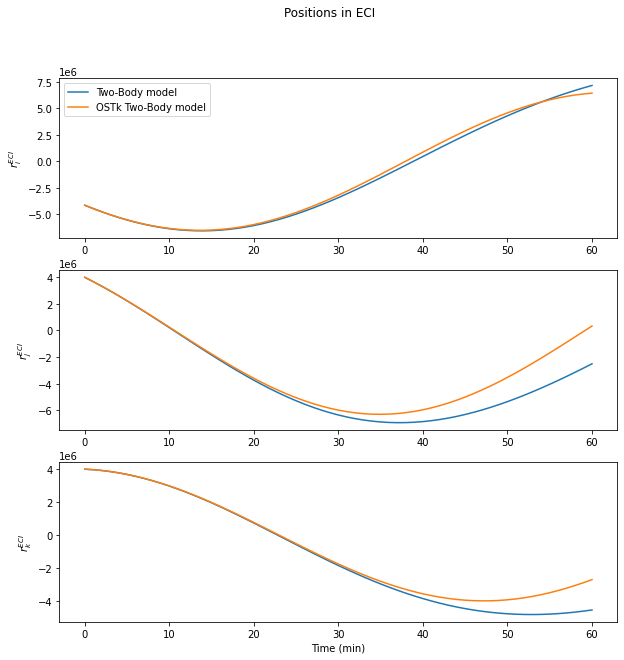

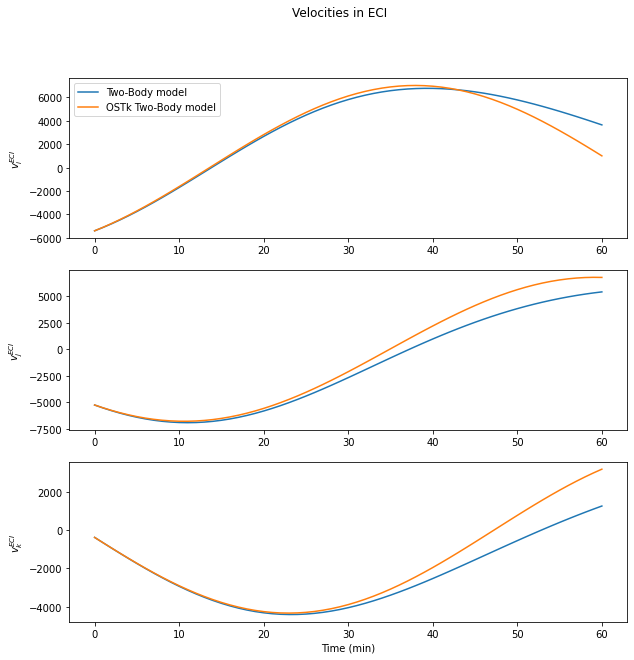

In [10]:
fig, axs = plt.subplots(3, figsize=((10,10)))
fig.suptitle('Positions in ECI')
axs[0].plot(X_kepler[:,0], label="Two-Body model")
axs[0].plot(keplerian_orbit_states[:,0], label="OSTk Two-Body model")
axs[0].set(ylabel="$r_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(X_kepler[:,1])
axs[1].plot(keplerian_orbit_states[:,1])
axs[1].set(ylabel="$r_j^{ECI}$")
axs[2].plot(X_kepler[:,2])
axs[2].plot(keplerian_orbit_states[:,2])
axs[2].set(xlabel="Time (min)", ylabel="$r_k^{ECI}$")

fig, axs = plt.subplots(3,  figsize=((10,10)))
fig.suptitle('Velocities in ECI')
axs[0].plot(X_kepler[:,3], label="Two-Body model")
axs[0].plot(keplerian_orbit_states[:,3], label="OSTk Two-Body model")
axs[0].set(ylabel="$v_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(X_kepler[:,4])
axs[1].plot(keplerian_orbit_states[:,4])
axs[1].set(ylabel="$v_j^{ECI}$")
axs[2].plot(X_kepler[:,5])
axs[2].plot(keplerian_orbit_states[:,5])
axs[2].set(xlabel="Time (min)", ylabel="$v_k^{ECI}$")

## J2 model

In [11]:
J2_model = Kepler(coe, epoch, earth, Kepler.PerturbationType.J2)
J2_orbit = Orbit(J2_model, earth)

In [12]:
J2_model.get_perturbation_type()

ostk.astrodynamics.trajectory.orbit.models.PerturbationType.J2

In [13]:
states = [J2_orbit.get_state_at(instant) for instant in instants]
J2_orbit_states = [convertState(state) for state in states]
J2_orbit_states = np.array(J2_orbit_states)

In [14]:
X0 = J2_orbit_states[0]
dt = step.in_seconds()

X_J2 = np.zeros((len(instants), 6))
X_J2[0,:] = X0
for i in range(1,len(instants)):
    X_J2[i,:] = propagator(X_J2[i-1,:], dt, j2Dynamics)

/home/jovyan/utils.py:12: RuntimeWarning:

overflow encountered in multiply



[Text(0, 0.5, '$v_k^{ECI}$'), Text(0.5, 0, 'Time (min)')]

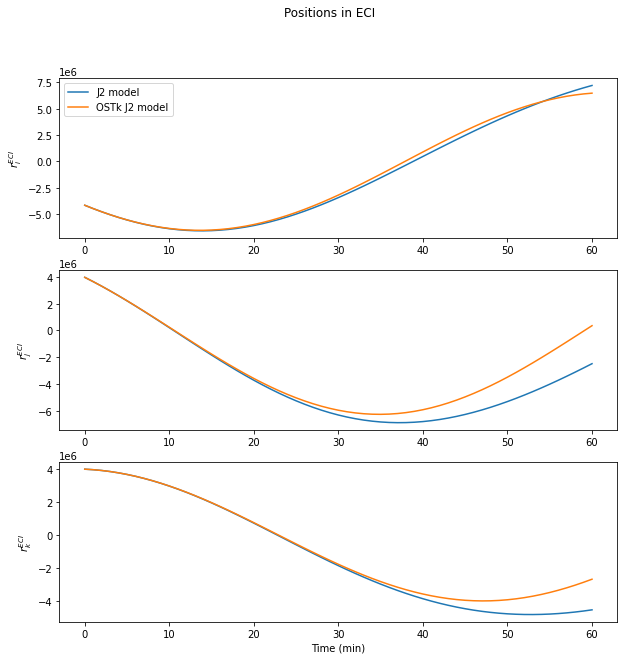

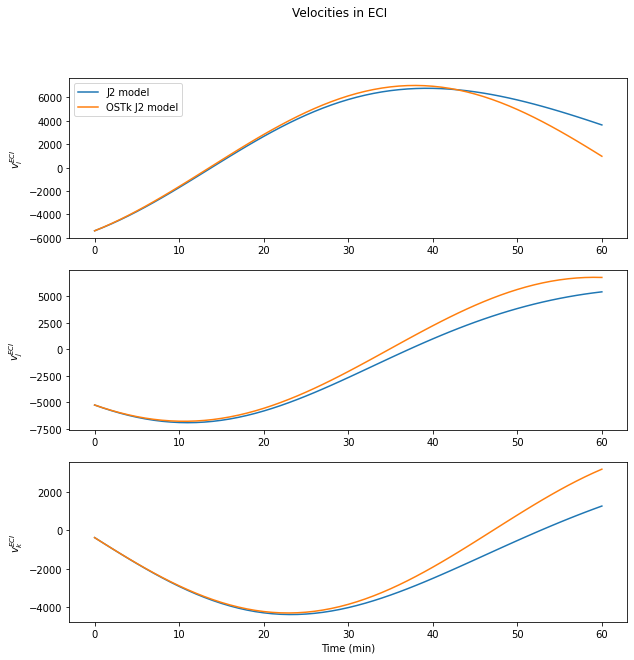

In [15]:
fig, axs = plt.subplots(3, figsize=((10,10)))
fig.suptitle('Positions in ECI')
axs[0].plot(X_J2[:,0], label="J2 model")
axs[0].plot(J2_orbit_states[:,0], label="OSTk J2 model")
axs[0].set(ylabel="$r_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(X_J2[:,1])
axs[1].plot(J2_orbit_states[:,1])
axs[1].set(ylabel="$r_j^{ECI}$")
axs[2].plot(X_J2[:,2])
axs[2].plot(J2_orbit_states[:,2])
axs[2].set(xlabel="Time (min)", ylabel="$r_k^{ECI}$")

fig, axs = plt.subplots(3, figsize=((10,10)))
fig.suptitle('Velocities in ECI')
axs[0].plot(X_J2[:,3], label="J2 model")
axs[0].plot(J2_orbit_states[:,3], label="OSTk J2 model")
axs[0].set(ylabel="$v_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(X_J2[:,4])
axs[1].plot(J2_orbit_states[:,4])
axs[1].set(ylabel="$v_j^{ECI}$")
axs[2].plot(X_J2[:,5])
axs[2].plot(J2_orbit_states[:,5])
axs[2].set(xlabel="Time (min)", ylabel="$v_k^{ECI}$")

## J2 + atmospheric drag model

In [16]:
X0 = J2_orbit_states[0]
dt = step.in_seconds()

X_drag = np.zeros((len(instants), 6))
X_drag[0,:] = X0
for i in range(1,len(instants)):
    X_drag[i,:] = propagator(X_drag[i-1,:], dt, dragDynamics)

/home/jovyan/utils.py:12: RuntimeWarning:

overflow encountered in multiply



[Text(0, 0.5, '$v_k^{ECI}$'), Text(0.5, 0, 'Time (min)')]

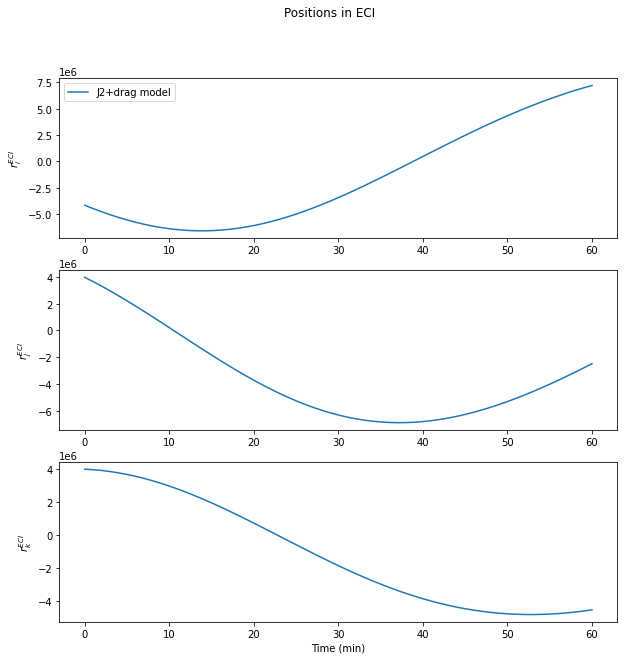

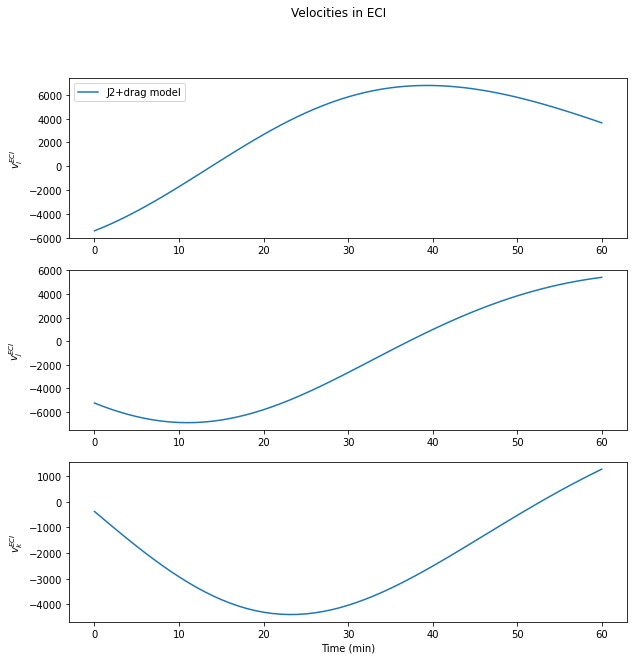

In [17]:
fig, axs = plt.subplots(3, figsize=((10,10)))
fig.suptitle('Positions in ECI')
axs[0].plot(X_drag[:,0], label="J2+drag model")
axs[0].set(ylabel="$r_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(X_drag[:,1])
axs[1].set(ylabel="$r_j^{ECI}$")
axs[2].plot(X_drag[:,2])
axs[2].set(xlabel="Time (min)", ylabel="$r_k^{ECI}$")

fig, axs = plt.subplots(3, figsize=((10,10)))
fig.suptitle('Velocities in ECI')
axs[0].plot(X_drag[:,3], label="J2+drag model")
axs[0].set(ylabel="$v_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(X_drag[:,4])
axs[1].set(ylabel="$v_j^{ECI}$")
axs[2].plot(X_drag[:,5])
axs[2].set(xlabel="Time (min)", ylabel="$v_k^{ECI}$")